## Data Exploration

In [ ]:
# Libraries

import os,sys
import pandas as pd
import numpy as np
from sklearn.externals import joblib
import seaborn as sns

import matplotlib.pyplot as plt

# Scikit
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.utils import resample
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression


In [ ]:
DATASET = '/dsa/home/jbhdw/jupyter/casestudy_data/group_8/ppp_with_one-hot_V2.csv'
assert os.path.exists(DATASET)

ppp = pd.read_csv(DATASET)

In [ ]:
ppp = ppp.iloc[:, 1:]

ppp.head()

### Adding additional columns to the Dataset
Additional features were required to complete our analysis. These include:

'CostPerJob'

This variable would allow us to look at these loans from the perspective of the cost per job for each approved dispersed loan. This variable provides is for what we called "bang for your buck" or how many jobs could be saved and the average cost of those jobs.

In [ ]:
ppp['CostPerJob'] = ppp['CurrentApprovalAmount'] / ppp['JobsReported']

In [ ]:
# Removing nans and infs to help with data size and data availability

ppp = ppp[~ppp.isin([np.nan, np.inf, -np.inf]).any(1)]

In [ ]:
ppp.describe()

In [ ]:
ppp.dtypes

### Pickle File Creation
With the clean dataset that contains only numeric variables and one-hot encoded variables we were able to run an ML pipeline on the data.

For ease of use the data was saved with a pickle file for future calls:

In [ ]:
#ppp_p = pd.read_pickle('/dsa/home/jbhdw/jupyter/casestudy_data/group_8/PPP_MAIN.pkl')

#ppp_p.head()

In [ ]:
#ppp_p.describe()

In [ ]:
#for c in ppp_p.columns:
    print(c)

### Phase

We created the phases based on the multiple iterations of PPP loans during the Covid 19 Pandemic.  This gave us a feel for the total amount and volume of loans through each iteration.

In [ ]:
# Split the dataframes into groups by phases

phase_1 = ppp.loc[ppp.Phase == 1]
phase_2 = ppp.loc[ppp.Phase == 2]
phase_3 = ppp.loc[ppp.Phase == 3]

In [ ]:
# Let's see how many loans each of the phases contained

print('Phase 1: ' + str(phase_1.shape[0]))
print('Phase 2: ' + str(phase_2.shape[0]))
print('Phase 3: ' + str(phase_3.shape[0]))

Phase 1 had the most loan applicants, followed by Phase 3.

**Now let's see how some other variables break out when compared to phases**

In [ ]:
%matplotlib inline
pd.crosstab(ppp.FranchiseYN,ppp.Phase).plot(kind='bar')
plt.title('Phase by Franchise')
plt.xlabel('Franchise Yes/No')
plt.ylabel('Frequency of Loans by Phase')

In [ ]:
%matplotlib inline
pd.crosstab(ppp.Party_D,ppp.Phase).plot(kind='bar')
plt.title('Phase by Democratic')
plt.xlabel('Party_D Yes/No')
plt.ylabel('Frequency of Loans by Phase')

In [ ]:
%matplotlib inline
pd.crosstab(ppp.Party_R,ppp.Phase).plot(kind='bar')
plt.title('Phase by Republican')
plt.xlabel('Party_R Yes/No')
plt.ylabel('Frequency of Loans by Phase')

### Additional Exploration
Additional exploration was done to analyze variable to determine any trends that could be easily identified and give us an idea of high level aggregates based on individual variables.

In [ ]:
DATASET = '/dsa/home/jbhdw/jupyter/casestudy_data/group_8/ppp_w3.csv'
assert os.path.exists(DATASET)

ppp1 = pd.read_csv(DATASET)

In [ ]:
ppp1.groupby('Gender')['Gender'].count()

In [ ]:
ppp1.groupby('Race')['Race'].count()

In [ ]:
ppp1.groupby('Term')['Term'].count()

In [ ]:
ppp1.groupby('RuralUrbanIndicator')['RuralUrbanIndicator'].count()

In [ ]:
ppp1.groupby('BusinessType')['BusinessType'].count()

In [ ]:
CORRELATIONS
On a larger scale, we took a look at how the variables correlate to one another.

ppp_cor = ppp.corr()

ppp_cor

sns.heatmap(ppp_cor, annot=True) plt.show()

ppp_cor.style.background_gradient(cmap='coolwarm', axis=None)

In [ ]:
f = plt.figure(figsize=(30, 25))
plt.matshow(ppp.corr(), fignum=f.number)
plt.xticks(range(ppp.select_dtypes(['number']).shape[1]), ppp.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(ppp.select_dtypes(['number']).shape[1]), ppp.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

### Machine Learning Beginning Exploration
**Feature Selection**

Now as we dove in to consider a model to predict early/late adopters we ran some feature selection to cull down the amount of variables and data.

In [ ]:
# Due to the large size of the data, initially we will down sample to preserve memory

#------------------------------NOTE--------------------------------------
# This will overwrite the ppp variable

ppp=ppp.loc[:,ppp.columns !='ForgivenessDate']
ppp=(ppp.sample(frac=.05))

In [ ]:
# Parse out the phases

X = np.array(ppp.loc[:,ppp.columns !='Phase'])
y = np.array(ppp.Phase)

Splitting the Data

Split the data 70/30 to create training and testing data sets

In [ ]:
# Start by defining the function. We will call within concurrent cells

def forward_selection_session(k=3): # Initial set to k=3
    selector = SelectKBest(mutual_info_regression, k=k)
    selector.fit(X_train, y_train)
    print(selector.get_support(True))
    model = LinearRegression()
    model.fit(selector.transform(X_train), y_train)
    return model.score(selector.transform(X_test), y_test)

In [ ]:
# Using base of k=3

forward_selection_session()

In [ ]:
# Update k=6

forward_selection_session(k=6)

In [ ]:
# Update k=24

forward_selection_session(k=24)

In [ ]:
# Update k=96

forward_selection_session(k=96)

### Exploratory Modeling
We attempted to use a linear model as we explored the data. We used selectKbest with a k of 6 as based on the prior feature selection there was minimal increase in score after 6 features being selected.

As this model was not ver proficient with our data we chose in the end to use a random forest model that can be found in our modeling notebook.

In [ ]:
selector = SelectKBest(chi2, k=6)
selector.fit(X_train, y_train)
print('χ² statistic', selector.scores_)

In [ ]:
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

### Final Visulaizations

These visualizations are based on our final data after carpentry was complete and the focus was shifted to two states Florida and Maryland.  This work was done in R and the code and visuals have ben captured in this notebook.

#load libraries

library(ggplot2)
library(dplyr)

ppp <- read.csv('/dsa/home/kg37m/jupyter/casestudy_data/group_8/ppp_w5.csv')

head(ppp)

#a little bit of data carpentry
#(1) drop unneeded columns

ppp <- select(ppp, -c(X, Unnamed..0, BorrowerAddress, ServicingLenderAddress, Party_R, Party_D))

ppp <- filter(ppp, (ProjectState == "FL") | (ProjectState == "MD"))

#(3) convert Phase to type character

ppp$Phase <- as.character(ppp$Phase)

typeof(ppp$Phase)

#(4) convert NonProfit from integars to factors
ppp$NonProfit[ppp$NonProfit == 0] <- "For Profit"
ppp$NonProfit[ppp$NonProfit == 1] <- "Non-Profit"

#(5) convert ForgivenYN from integars to factors
ppp$ForgivenYN[ppp$ForgivenYN == 0] <- "Not Forgiven"
ppp$ForgivenYN[ppp$ForgivenYN == 1] <- "Forgiven"

head(ppp)

#now for some visual plots
#we'll start by looking at Phase, separating by state
p1 <- ggplot(ppp, aes(Phase, fill = Phase)) + geom_bar() + 
    facet_wrap(~ProjectState) + 
    theme_bw() +
    theme(legend.position = "none")
p1

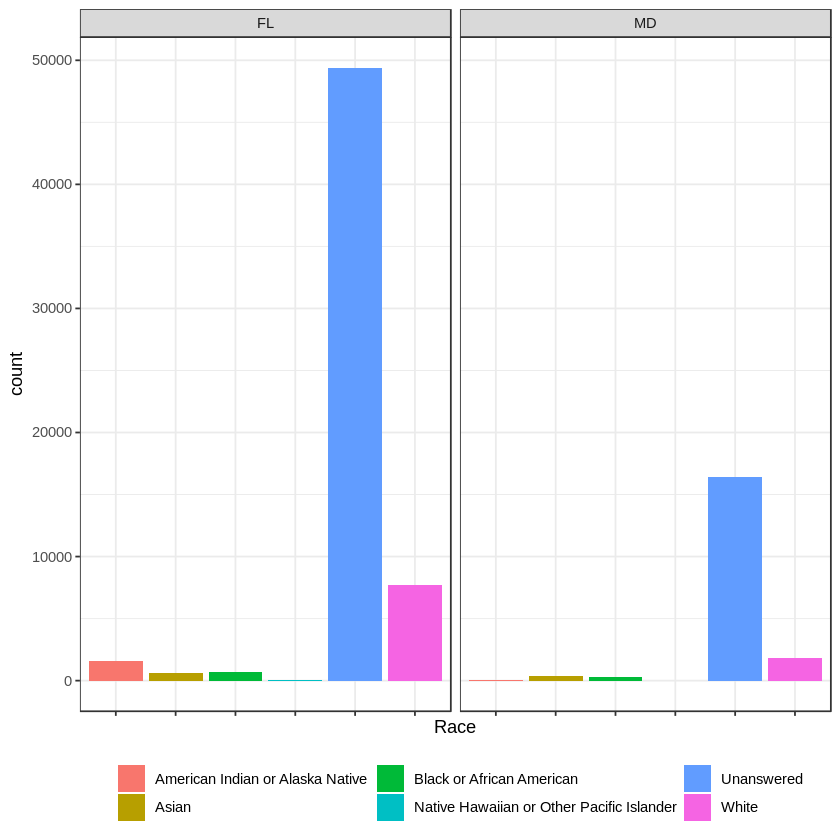

#graph for rural/urban
p2 <- ggplot(ppp, aes(RuralUrbanIndicator, fill = RuralUrbanIndicator)) + geom_bar() + 
    facet_wrap(~ProjectState) + 
    theme_bw() +
    theme(legend.position = "none") +
    labs(x = "Rural/Urban Indicator") +
    scale_x_discrete(labels = c("Rural", "Urban"))
p2

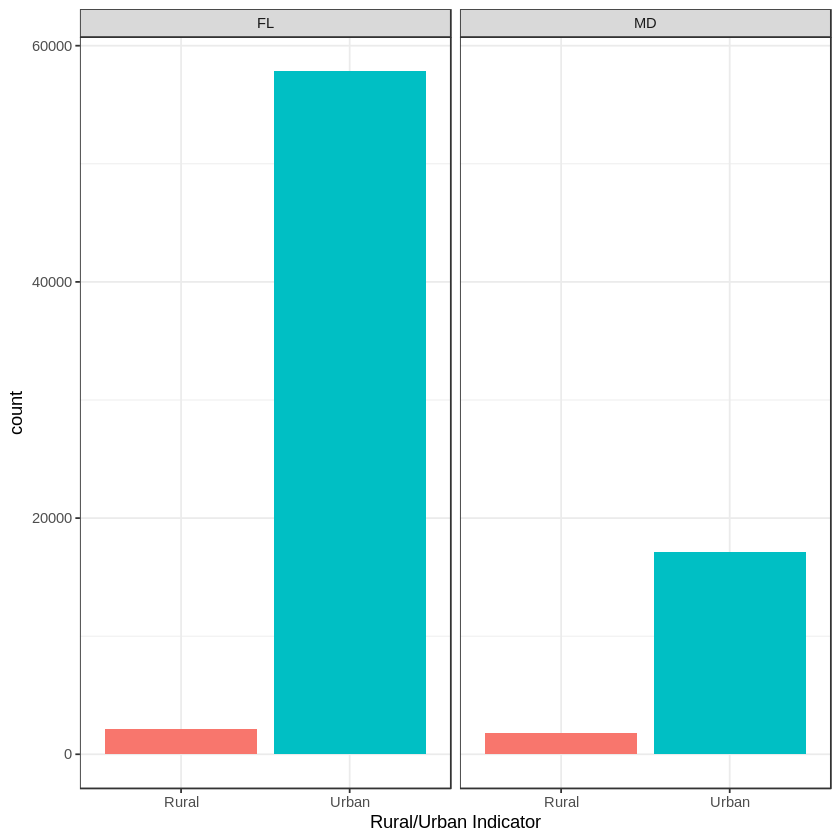

#graph for hub/nonhub
p3 <- ggplot(ppp, aes(HubzoneIndicator, fill = HubzoneIndicator)) + geom_bar() + 
    facet_wrap(~ProjectState) + 
    theme_bw() +
    theme(legend.position = "none") +
    labs(x = "Hubzone Indicator") +
    scale_x_discrete(labels = c("Non-Hubzone", "Hubzone"))
p3

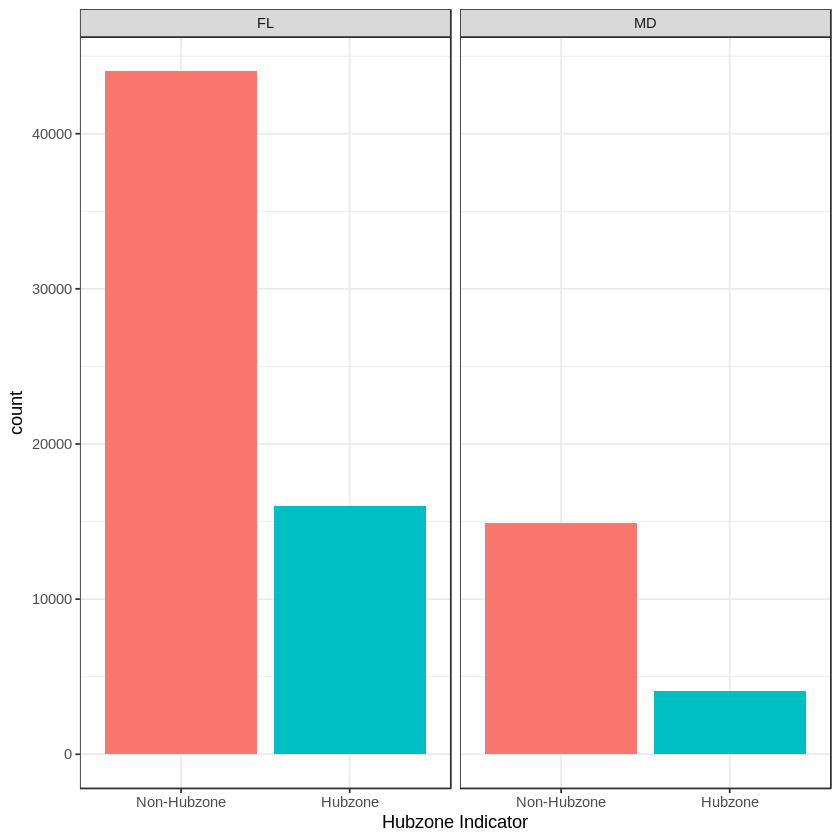

#graph for race
p4 <- ggplot(ppp, aes(Race, fill = Race)) + geom_bar() + 
    facet_wrap(~ProjectState)  + 
    theme_bw() +
    theme(legend.position = "bottom",
          legend.title = element_blank(),
          axis.text.x = element_blank())
p4

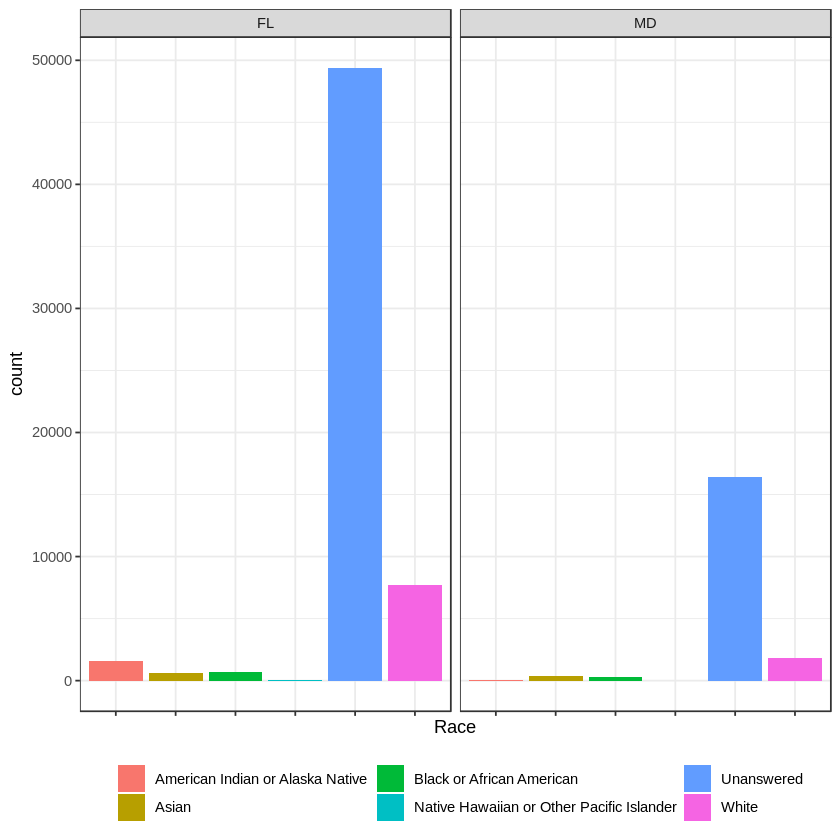

#graph for ethnicity
p5 <- ggplot(ppp, aes(Ethnicity, fill = Ethnicity)) + geom_bar() + 
    facet_wrap(~ProjectState)  + 
    theme_bw() +
    theme(legend.position = "bottom",
          legend.title = element_blank(),
          axis.text.x = element_blank())
p5

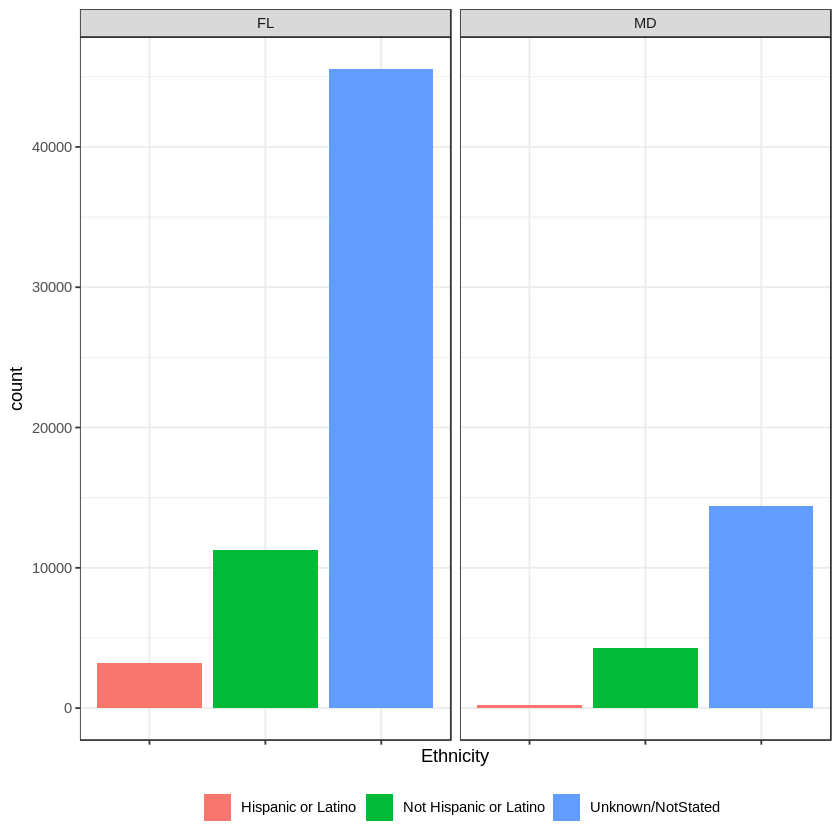

#to make the Business Type chart a little easier to process,
#I'll create a pp_less data set for only business types with
#counts > 100

#get counts for each Business Type
table(ppp$BusinessType)

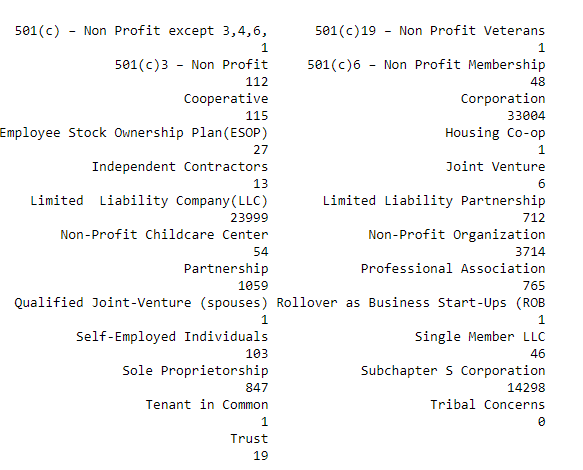

#create list of types with count > 100
keep <- c("501(c)3 – Non Profit", 
         "Cooperative",
         "Limited  Liability Company(LLC)",
         "Partnership",
         "Self-Employed Individuals",
         "Sole Proprietorship",
         "Corporation",
         "Limited Liability Partnership",
         "Non-Profit Organization",
         "Professional Association",
         "Subchapter S Corporation")

#now keep only rows that ave these business types
ppp_less <- filter(ppp, BusinessType %in% keep)

#graph for business type
p6 <- ggplot(ppp_less, aes(BusinessType, fill = BusinessType)) + geom_bar() + 
    facet_wrap(~ProjectState)  + 
    theme_bw() +
    theme(legend.position = "bottom",
          legend.title = element_blank(),
          axis.text.x = element_blank()) +
    labs(x = "Business Type (for types with count > 100)")
p6

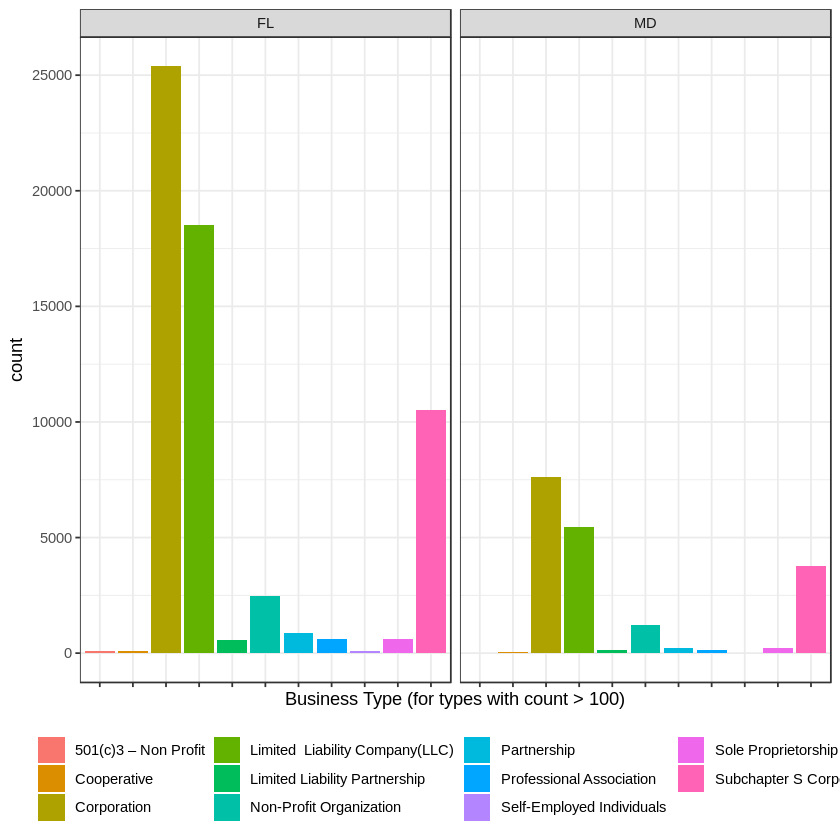

#graph for gender
p7 <- ggplot(ppp, aes(Gender, fill = Gender)) + geom_bar() + 
    facet_wrap(~ProjectState) + 
    theme_bw() +
        theme(legend.position = "bottom",
          legend.title = element_blank(),
          axis.text.x = element_blank())  +
    labs(x = "Ownership by Gender")
p7

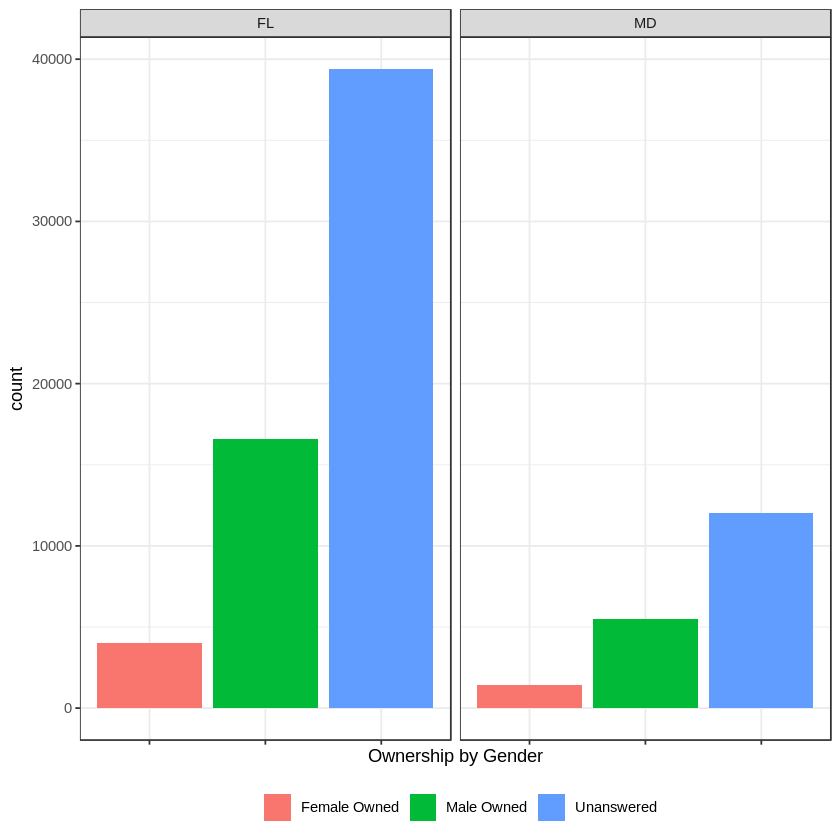

#graph for veteran
p8 <- ggplot(ppp, aes(Veteran, fill = Veteran)) + geom_bar() + 
    facet_wrap(~ProjectState) + 
    theme_bw() +
        theme(legend.position = "bottom",
          legend.title = element_blank(),
          axis.text.x = element_blank())  +
    labs(x = "Ownership by Veteran Status")
p8

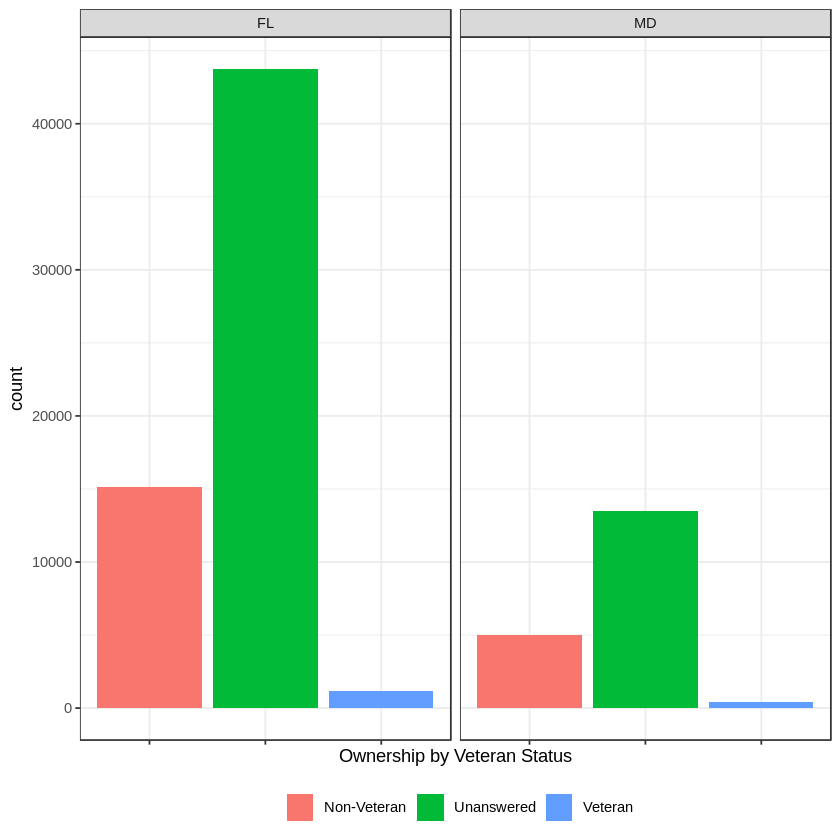

#graph for vnonprofit
p9 <- ggplot(ppp, aes(NonProfit, fill = NonProfit)) + geom_bar() + 
    facet_wrap(~ProjectState) + 
    theme_bw() +
    theme(legend.position = "none") +
    labs(x = "Non-Profit Status")
p9

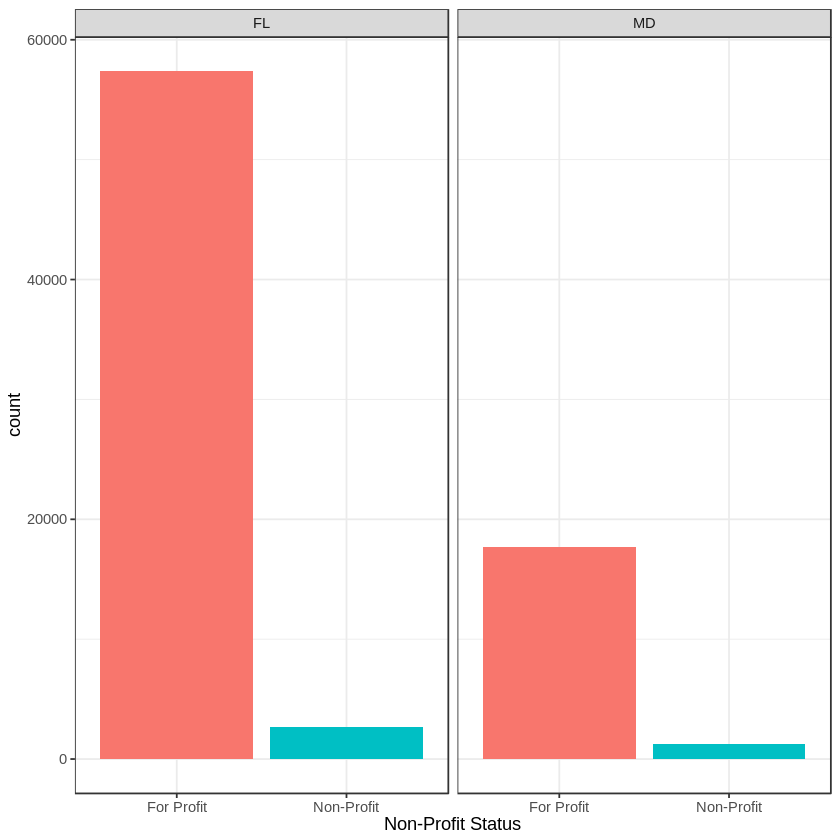

#graph for forgiveness
p10 <- ggplot(ppp, aes(ForgivenYN, fill = ForgivenYN)) + geom_bar() + 
    facet_wrap(~ProjectState) + 
    theme_bw() +
    theme(legend.position = "none") +
    labs(x = "Loan Forgiveness Status")
p10

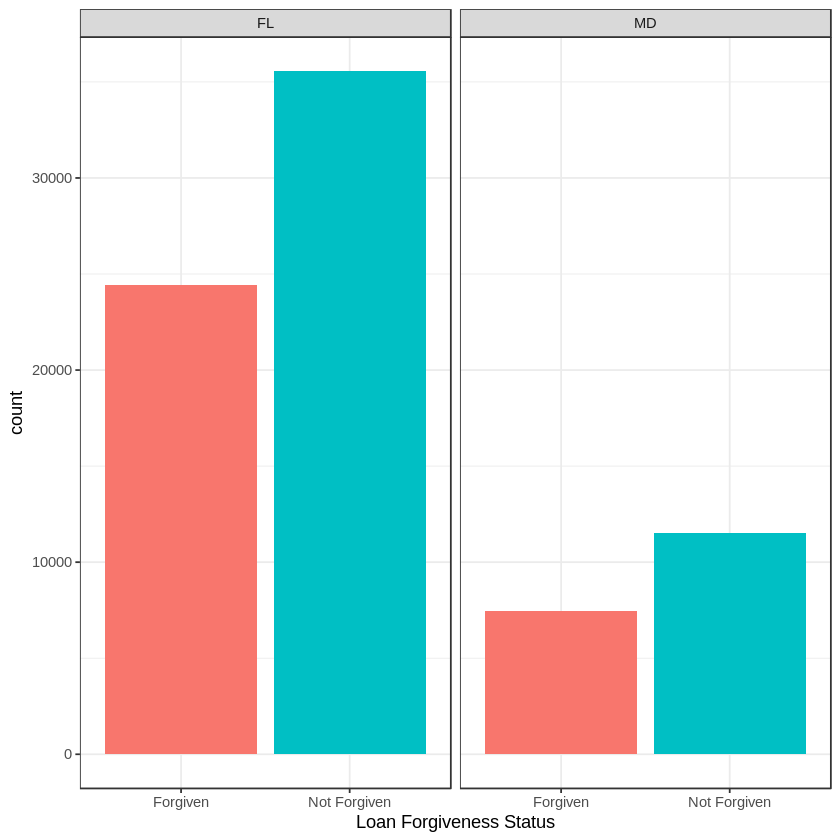

#and we can export all of our graphs for use in the final presentation
png("phase.png")
p1
dev.off()

png("ruralurban.png")
p2
dev.off()

png("hubzone.png")
p3
dev.off()

png("race.png")
p4
dev.off()

png("ethnicity.png")
p5
dev.off()

png("type.png")
p6
dev.off()

png("gender.png")
p7
dev.off()

png("nonprofit.png")
p9
dev.off()

png("forgiveness.png")
p10
dev.off()

#getting some summary statistics for the presentation

#starting by separating FL and MD
ppp_fl <- filter(ppp, ProjectState == "FL")
ppp_md <- filter(ppp, ProjectState == "MD")

#total number of loans in FL
count(ppp_fl)

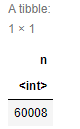

#total number of loans in MD
count(ppp_md)

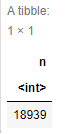

#total amount approved in FL
sum(ppp_fl$CurrentApprovalAmount)

28209536288.29

#total amount approved in MD
sum(ppp_md$CurrentApprovalAmount)

10105391636.33